---
title: Módulo 5
subtitle: Métodos no supervisados
author:
  - name: Eloy Alvarado Narváez
    orcid: 0000-0001-7522-2327
    email: eloy.alvarado@usm.cl
    affiliations: Universidad Técnica Federico Santa María
  - name: Esteban Salgado Valenzuela
    orcid: 0000-0002-7799-0044
    affiliations: Universidad Técnica Federico Santa María
date: 14/12/2024
---

En este laboratorio, veremos el Análisis de Componentes Principales (PCA) y la agrupación (clustering) en varios conjuntos de datos.

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.datasets import get_rdataset
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from ISLP import load_data

from sklearn.cluster import \
     (KMeans,
      AgglomerativeClustering)
from scipy.cluster.hierarchy import \
     (dendrogram,
      cut_tree)
from ISLP.cluster import compute_linkage

#### Análisis de Componentes Principales

En este laboratorio, llevamos a cabo un Análisis de Componentes Principales (PCA) sobre `USArrests`, un conjunto de datos del entorno de programación `R`. Recuperamos los datos utilizando la función `get_rdataset()`, la cual puede obtener información de numerosos paquetes estándar de `R`.

Las filas del conjunto de datos representan los 50 estados de Estados Unidos, ordenados alfabéticamente.

In [3]:
USArrests = get_rdataset('USArrests').data
USArrests.head()

,Murder,Assault,UrbanPop,Rape
rownames,,,,
Alabama,13.2,236,58,21.2
Alaska,10.0,263,48,44.5
Arizona,8.1,294,80,31.0
Arkansas,8.8,190,50,19.5
California,9.0,276,91,40.6


Primero examinamos brevemente los datos. Notamos que las variables tienen medias muy diferentes.

In [4]:
USArrests.mean()

Murder        7.788
Assault     170.760
UrbanPop     65.540
Rape         21.232
dtype: float64

Los `DataFrames` tienen varios métodos útiles para calcular resúmenes por columna. También podemos examinar la varianza de las cuatro variables utilizando el método `var()`.

In [6]:
USArrests.var()

Murder        18.970465
Assault     6945.165714
UrbanPop     209.518776
Rape          87.729159
dtype: float64

No es sorprendente que las variables también presenten varianzas muy diferentes. La variable `UrbanPop` mide el porcentaje de la población en cada estado que vive en áreas urbanas, lo cual no es un número comparable al de asesinatos en cada estado por cada $100000$ individuos. El Análisis de Componentes Principales (PCA) busca variables derivadas que expliquen la mayor parte de la varianza en el conjunto de datos. Si no escalamos las variables antes de realizar el PCA, los componentes principales serán principalmente impulsados por la variable `Assault`, ya que posee la varianza más grande por mucho. Por lo tanto, si las variables se miden en diferentes unidades o varían ampliamente en escala, se recomienda estandarizarlas para que tengan una desviación estándar de uno antes de realizar el PCA. Típicamente, también ajustamos las medias a cero.

Este escalado se puede realizar mediante la transformación `StandardScaler()` importada anteriormente. Primero ajustamos el escalador, lo que calcula las medias y desviaciones estándar necesarias, y luego lo aplicamos a nuestros datos utilizando el método `transform`. Como antes, combinamos estos pasos utilizando el método `fit_transform()`.

In [7]:
scaler = StandardScaler(with_std=True,
                        with_mean=True)
USArrests_scaled = scaler.fit_transform(USArrests)

Después de escalar los datos, podemos realizar un Análisis de Componentes Principales utilizando la transformación `PCA()` del paquete `sklearn.decomposition`.

In [8]:
pcaUS = PCA()

(Por defecto, la transformación `PCA()` centra las variables para que tengan una media de cero, aunque no las escala.) La transformación `pcaUS` puede utilizarse para obtener las puntuaciones de PCA que devuelve el método `fit()`. Una vez que se ha llamado al método `fit`, el objeto `pcaUS` también contiene una serie de cantidades útiles.

In [9]:
pcaUS.fit(USArrests_scaled)

PCA()

Después de ajustar el modelo, el atributo `mean_` corresponde a las medias de las variables. En este caso, dado que centramos y escalamos los datos con `scaler()`, todas las medias serán 0

In [10]:
pcaUS.mean_

array([-7.10542736e-17,  1.38777878e-16, -4.39648318e-16,  8.59312621e-16])

Las puntuaciones se pueden calcular utilizando el método `transform()` de `pcaUS` una vez que ha sido ajustado.

In [11]:
scores = pcaUS.transform(USArrests_scaled)

Más adelante, graficaremos estas puntuaciones. El atributo `components_` proporciona las cargas de los componentes principales: cada fila de `pcaUS.components_` contiene el vector de cargas correspondiente al componente principal.

In [12]:
pcaUS.components_ 

array([[ 0.53589947,  0.58318363,  0.27819087,  0.54343209],
       [-0.41818087, -0.1879856 ,  0.87280619,  0.16731864],
       [-0.34123273, -0.26814843, -0.37801579,  0.81777791],
       [-0.6492278 ,  0.74340748, -0.13387773, -0.08902432]])

El biplot es un método de visualización comúnmente utilizado en el Análisis de Componentes Principales (PCA). Aunque no está incorporado de forma estándar en `sklearn`, existen paquetes de `Python` que generan este tipo de gráficos. En este caso, construiremos manualmente un biplot sencillo.

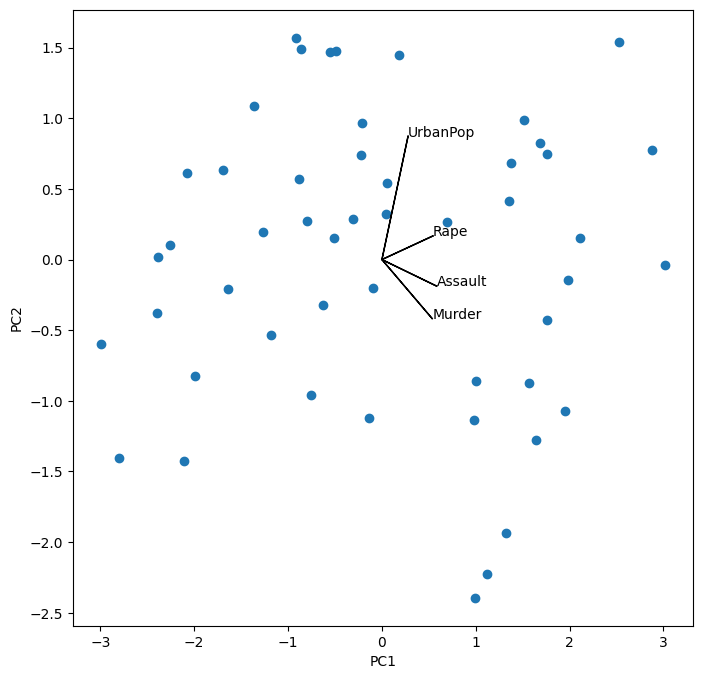

In [13]:
i, j = 0, 1 # which components
fig, ax = plt.subplots(1, 1, figsize=(8, 8))
ax.scatter(scores[:,0], scores[:,1])
ax.set_xlabel('PC%d' % (i+1))
ax.set_ylabel('PC%d' % (j+1))
for k in range(pcaUS.components_.shape[1]):
    ax.arrow(0, 0, pcaUS.components_[i,k], pcaUS.components_[j,k])
    ax.text(pcaUS.components_[i,k],
            pcaUS.components_[j,k],
            USArrests.columns[k])

Recordemos que los componentes principales son únicos hasta un cambio de signo, por lo que podemos reproducir esa figura invirtiendo los signos del segundo conjunto de puntuaciones y cargas. Además, aumentamos la longitud de las flechas para resaltar las cargas.

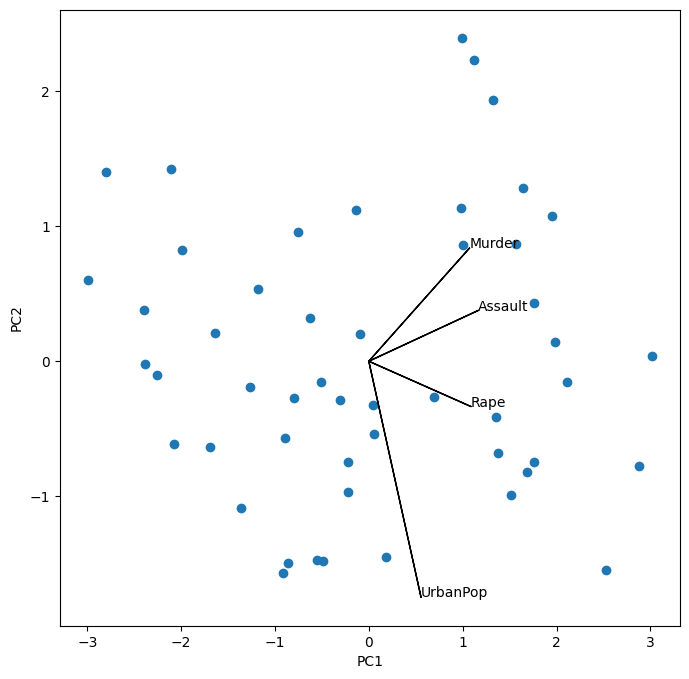

In [14]:
scale_arrow = s_ = 2
scores[:,1] *= -1
pcaUS.components_[1] *= -1 # flip the y-axis
fig, ax = plt.subplots(1, 1, figsize=(8, 8))
ax.scatter(scores[:,0], scores[:,1])
ax.set_xlabel('PC%d' % (i+1))
ax.set_ylabel('PC%d' % (j+1))
for k in range(pcaUS.components_.shape[1]):
    ax.arrow(0, 0, s_*pcaUS.components_[i,k], s_*pcaUS.components_[j,k])
    ax.text(s_*pcaUS.components_[i,k],
            s_*pcaUS.components_[j,k],
            USArrests.columns[k])

Las desviaciones estándar de las puntuaciones de los componentes principales son las siguientes:

In [16]:
scores.std(0, ddof=1)

array([1.5908673 , 1.00496987, 0.6031915 , 0.4206774 ])

La varianza de cada puntuación puede extraerse directamente del objeto `pcaUS` mediante el atributo `explained_variance_`.

In [17]:
pcaUS.explained_variance_

array([2.53085875, 1.00996444, 0.36383998, 0.17696948])

La proporción de varianza explicada por cada componente principal (PVE) se almacena en `explained_variance_ratio_`:

In [18]:
pcaUS.explained_variance_ratio_

array([0.62006039, 0.24744129, 0.0891408 , 0.04335752])

Vemos que el primer componente principal explica el $62.0\%$ de la varianza en los datos, el siguiente componente principal explica el $24.7\%$ de la varianza, y así sucesivamente. Podemos graficar la Proporción de Varianza Explicada (PVE) por cada componente, así como el PVE acumulado. Primero, graficamos la proporción de varianza explicada.

In [19]:
%%capture
fig, axes = plt.subplots(1, 2, figsize=(15, 6))
ticks = np.arange(pcaUS.n_components_)+1
ax = axes[0]
ax.plot(ticks,
        pcaUS.explained_variance_ratio_,
        marker='o')
ax.set_xlabel('Principal Component');
ax.set_ylabel('Proportion of Variance Explained')
ax.set_ylim([0,1])
ax.set_xticks(ticks)

Observe el uso de %%capture, que suprime la visualización de la figura parcialmente completada.

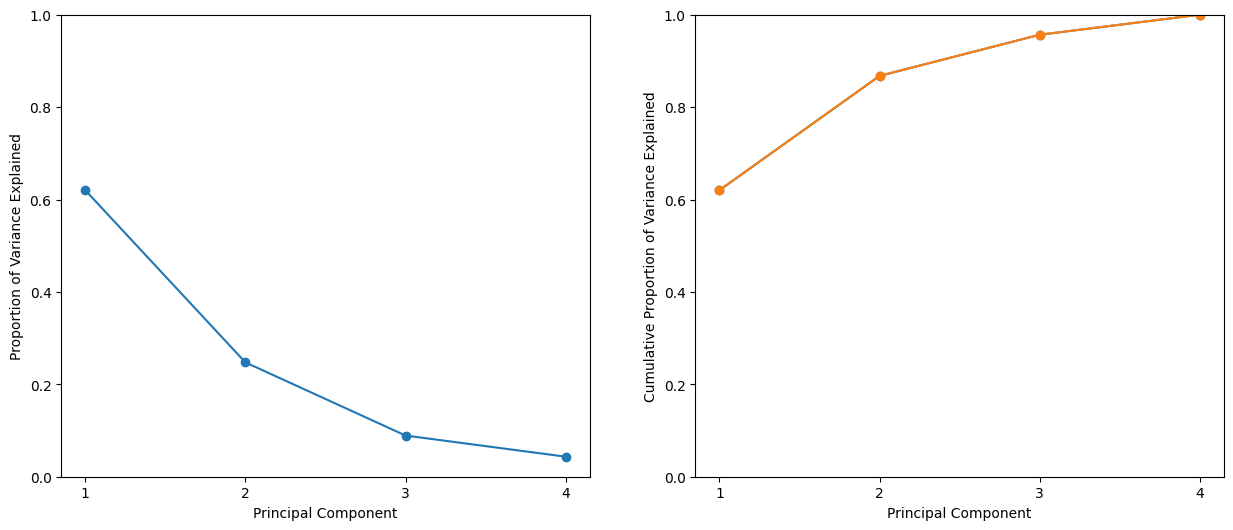

In [21]:
ax = axes[1]
ax.plot(ticks,
        pcaUS.explained_variance_ratio_.cumsum(),
        marker='o')
ax.set_xlabel('Principal Component')
ax.set_ylabel('Cumulative Proportion of Variance Explained')
ax.set_ylim([0, 1])
ax.set_xticks(ticks)
fig

Observe que el método `cumsum()` calcula la suma acumulativa de los elementos de un vector numérico. Por ejemplo:

#### Clustering

##### K-Means Clustering

El estimador `sklearn.cluster.KMeans()` realiza el agrupamiento $K$-means en `Python`. Comenzamos con un ejemplo simulado sencillo en el que realmente existen dos grupos en los datos: las primeras 25 observaciones presentan un desplazamiento en la media en comparación con las siguientes 25 observaciones.

In [22]:
np.random.seed(0)
X = np.random.standard_normal((50,2))
X[:25,0] += 3
X[:25,1] -= 4

Ahora realizamos un agrupamiento $K$-means con $K=2$.

In [23]:
kmeans = KMeans(n_clusters=2,
                random_state=2,
                n_init=20).fit(X)

Especificamos `random_state` para garantizar la reproducibilidad de los resultados. Las asignaciones de clúster para las 50 observaciones están almacenadas en `kmeans.labels_`.

In [24]:
kmeans.labels_

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1,
       0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1], dtype=int32)

El agrupamiento $K$-means separó perfectamente las observaciones en dos grupos, aunque no proporcionamos ninguna información de grupo a `KMeans()`. Podemos graficar los datos, con cada observación coloreada según su asignación de clúster.

Text(0.5, 1.0, 'Resultados de $K$-Means Clustering con K=2')

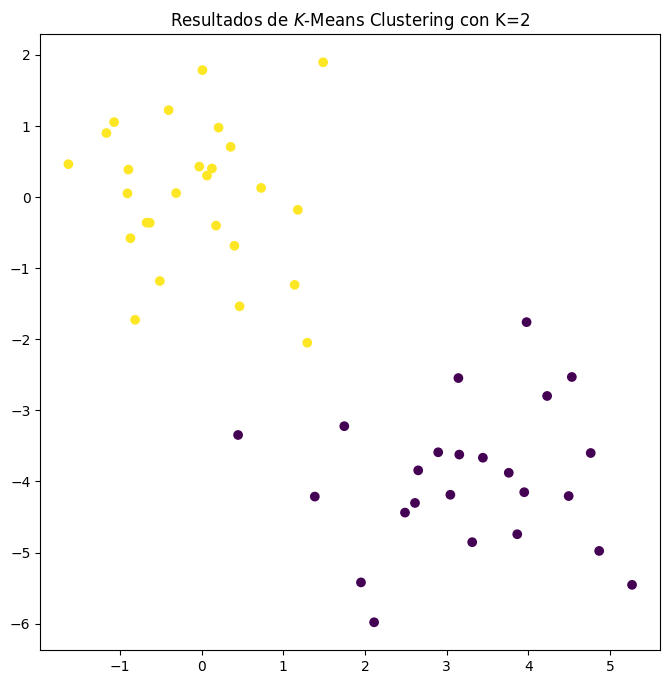

In [31]:
#colors = {0:'blue',1:'red'}
#kmin_cols = [colors[i] for i in kmeans.labels_]
kmin_cols = kmeans.labels_

fig, ax = plt.subplots(1, 1, figsize=(8,8))
ax.scatter(X[:,0], X[:,1], c=kmin_cols)
ax.set_title(r"Resultados de $K$-Means Clustering con K=2")

Aquí las observaciones pueden representarse fácilmente gráficamente porque son bidimensionales. Si hubiera más de dos variables, podríamos realizar un Análisis de Componentes Principales (PCA) y graficar los dos primeros vectores de puntuaciones de los componentes principales para representar los clústeres.

En este ejemplo, sabíamos que realmente existían dos clústeres porque generamos los datos. Sin embargo, para datos reales, no conocemos el número verdadero de clústeres ni si estos existen de manera precisa. En su lugar, podríamos haber realizado un agrupamiento $K$-means en este ejemplo con $K=3$.

Text(0.5, 1.0, 'K-Means Clustering Results with K=3')

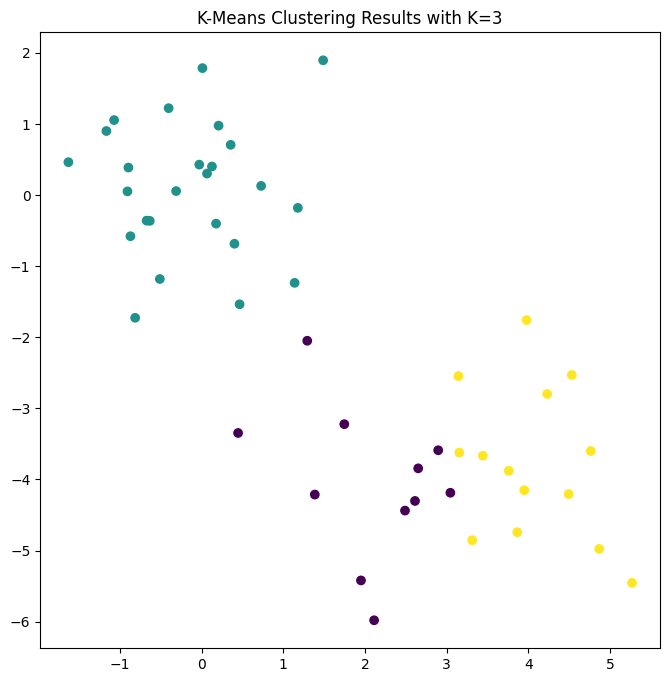

In [32]:
kmeans = KMeans(n_clusters=3,
                random_state=3,
                n_init=20).fit(X)
fig, ax = plt.subplots(figsize=(8,8))
ax.scatter(X[:,0], X[:,1], c=kmeans.labels_)
ax.set_title("K-Means Clustering Results with K=3")

Cuando $K=3$, el agrupamiento $K$-means separa los dos clústeres. Hemos utilizado el argumento `n_init` para ejecutar $K$-means con 20 asignaciones iniciales de clúster (el valor predeterminado es 10). Si se utiliza un valor de `n_init` mayor que uno, el agrupamiento $K$-means se realizará mediante múltiples asignaciones aleatorias y la función `KMeans()` reportará únicamente los mejores resultados. Aquí comparamos el uso de `n_init=1` con `n_init=20`.

In [35]:
kmeans1 = KMeans(n_clusters=3,
                random_state=3,
                n_init=1).fit(X)
kmeans20 = KMeans(n_clusters=3,
                  random_state=3,
                  n_init=20).fit(X);
kmeans1.inertia_, kmeans20.inertia_

(76.85131986999251, 75.06261242745383)

Observamos que `kmeans.inertia_` es la suma total de cuadrados dentro de los clústeres, la cual buscamos minimizar al realizar el agrupamiento $K$-means.

Se recomienda ejecutar el agrupamiento $K$-means con un valor grande de `n_init`, como $20$ o $50$, ya que de lo contrario se podría obtener un óptimo local indeseable.

Al realizar el agrupamiento $K$-means, además de utilizar múltiples asignaciones iniciales de clúster, también es importante establecer una semilla aleatoria utilizando el argumento `random_state` en `KMeans()`. De esta manera, las asignaciones iniciales de clúster pueden ser replicadas, y el *output* de $K$-means será completamente reproducible.

#### Clustering Jerárquico

La clase `AgglomerativeClustering()` del paquete `sklearn.clustering` implementa el agrupamiento jerárquico. Debido a que su nombre es largo, utilizamos la abreviatura `HClust` para referirnos al agrupamiento jerárquico. Es importante notar que esto no cambia el tipo de retorno al utilizar este método, por lo que las instancias seguirán siendo de la clase `AgglomerativeClustering`. En el siguiente ejemplo, empleamos los datos anteriores para graficar el *dendrograma* del agrupamiento jerárquico utilizando los métodos de enlace completo, enlace simple y enlace promedio, con la distancia Euclidiana como medida de disimilitud. Comenzamos agrupando las observaciones utilizando el enlace completo.

In [37]:
HClust = AgglomerativeClustering
hc_comp = HClust(distance_threshold=0,
                 n_clusters=None,
                 linkage='complete')
hc_comp.fit(X)

AgglomerativeClustering(distance_threshold=0, linkage='complete',
                        n_clusters=None)

Esto calcula el dendrograma completo. Podríamos realizar el agrupamiento jerárquico utilizando enlace promedio o enlace simple de la misma manera:

In [38]:
hc_avg = HClust(distance_threshold=0,
                n_clusters=None,
                linkage='average')
hc_avg.fit(X)
hc_sing = HClust(distance_threshold=0,
                 n_clusters=None,
                 linkage='single')
hc_sing.fit(X)

AgglomerativeClustering(distance_threshold=0, linkage='single', n_clusters=None)

Para utilizar una matriz de distancias precomputada, proporcionamos un argumento adicional `metric="precomputed"`. En el código a continuación, las primeras cuatro líneas calculan la matriz de distancias pareadas de $50\times50$.

In [40]:


D = np.zeros((X.shape[0], X.shape[0]));
for i in range(X.shape[0]):
    x_ = np.multiply.outer(np.ones(X.shape[0]), X[i])
    D[i] = np.sqrt(np.sum((X - x_)**2, 1))

hc_sing_pre = HClust(distance_threshold=0,
                     n_clusters=None,
                     metric='precomputed',
                     linkage='single')
hc_sing_pre.fit(D)


AgglomerativeClustering(distance_threshold=0, linkage='single',
                        metric='precomputed', n_clusters=None)

Utilizamos la función `dendrogram()` del módulo `scipy.cluster.hierarchy` para graficar el dendrograma. Sin embargo, `dendrogram()` espera una representación conocida como matriz de enlaces (*linkage-matrix*) del clustering, la cual no es proporcionada por `AgglomerativeClustering()`, pero puede ser calculada. Para este propósito, se dispone de la función `compute_linkage()` en el paquete `ISLP.cluster`.

Ahora podemos graficar los dendrogramas. Los números en la parte inferior de la gráfica identifican cada observación. La función `dendrogram()` incluye un método predeterminado para colorear diferentes ramas del árbol, lo que sugiere un corte predefinido del árbol a una profundidad específica. Preferimos sobrescribir este comportamiento por defecto estableciendo este umbral como infinito. Dado que deseamos aplicar este comportamiento a múltiples dendrogramas, almacenamos estos valores en un diccionario llamado `cargs` y los pasamos como argumentos de palabra clave utilizando la notación `**cargs`.

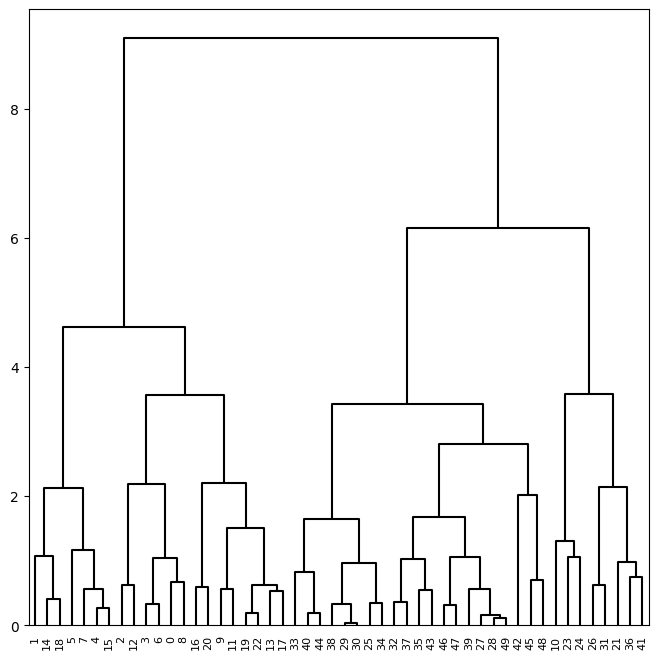

In [44]:
cargs = {'color_threshold':-np.inf,
         'above_threshold_color':'black'}
linkage_comp = compute_linkage(hc_comp)
fig, ax = plt.subplots(1, 1, figsize=(8, 8))
dnd = dendrogram(linkage_comp,
                 ax=ax,
                 **cargs)


Podríamos desear colorear las ramas del árbol de manera diferente por encima y por debajo de un umbral de corte. Esto se puede lograr modificando el parámetro `color_threshold`. Vamos a cortar el árbol a una altura de 4, coloreando las uniones que se fusionan por encima de 4 en negro.

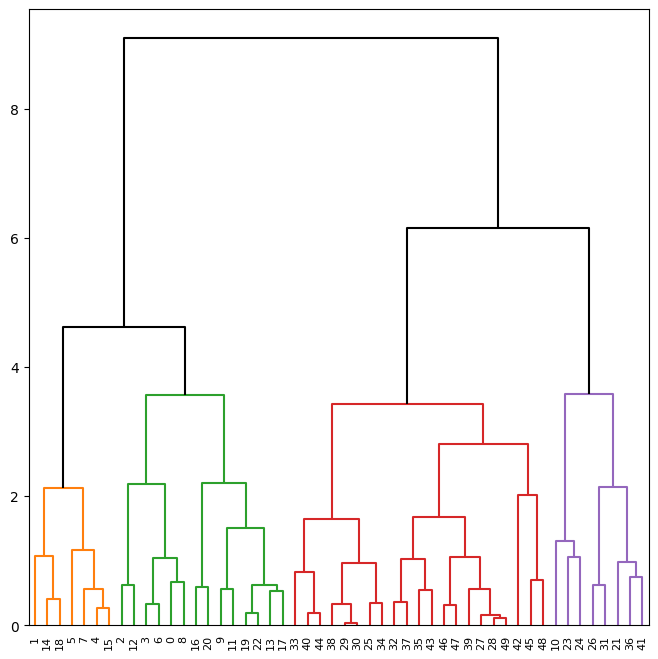

In [46]:
fig, ax = plt.subplots(1, 1, figsize=(8, 8))
dnd = dendrogram(linkage_comp,
                 ax=ax,
                 color_threshold=4,
                 above_threshold_color='black')

Para determinar las etiquetas de clúster para cada observación asociada a un corte específico del dendrograma, podemos utilizar la función `cut_tree()` del módulo `scipy.cluster.hierarchy`:

In [47]:
cut_tree(linkage_comp, n_clusters=4).T

array([[0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 2, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 2,
        0, 2, 2, 3, 2, 3, 3, 3, 3, 2, 3, 3, 3, 3, 2, 3, 3, 3, 3, 2, 3, 3,
        3, 3, 3, 3, 3, 3]])

Esto también se puede lograr proporcionando un argumento `n_clusters` a `HClust()`; sin embargo, cada corte requeriría recalcular el clustering. De manera similar, los árboles pueden ser cortados por un umbral de distancia mediante un argumento `distance_threshold` en `HClust()` o `height` en `cut_tree()`.

In [48]:
cut_tree(linkage_comp, height=5)

array([[0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [1],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [1],
       [0],
       [1],
       [1],
       [2],
       [1],
       [2],
       [2],
       [2],
       [2],
       [1],
       [2],
       [2],
       [2],
       [2],
       [1],
       [2],
       [2],
       [2],
       [2],
       [1],
       [2],
       [2],
       [2],
       [2],
       [2],
       [2],
       [2],
       [2]])

Para escalar las variables antes de realizar el agrupamiento jerárquico de las observaciones, utilizamos `StandardScaler()` como en nuestro ejemplo de PCA:

Text(0.5, 1.0, 'Clustering Jerárquico con Características Escaladas')

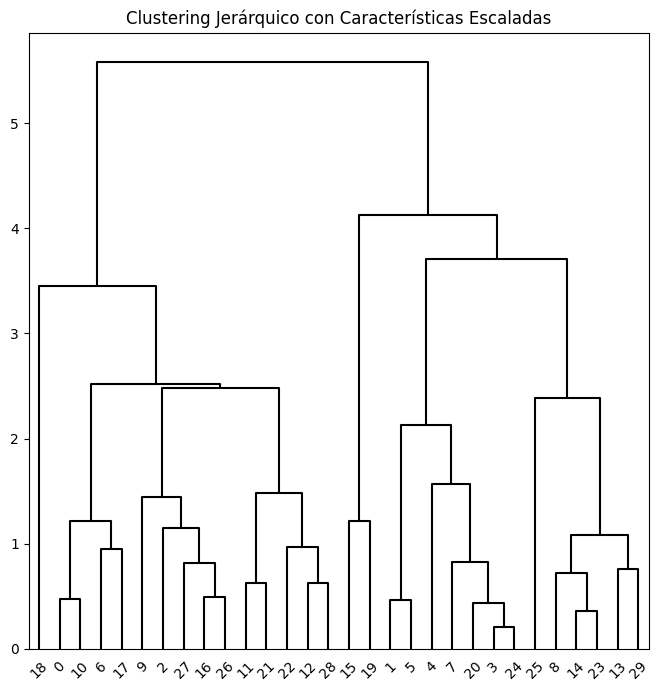

In [58]:
scaler = StandardScaler()
X_scale = scaler.fit_transform(X)
hc_comp_scale = HClust(distance_threshold=0,
                       n_clusters=None,
                       linkage='complete').fit(X_scale)
linkage_comp_scale = compute_linkage(hc_comp_scale)
fig, ax = plt.subplots(1, 1, figsize=(8, 8))
dendrogram(linkage_comp_scale, ax=ax, **cargs)
ax.set_title("Clustering Jerárquico con Características Escaladas")

Las distancias basadas en la correlación entre observaciones pueden utilizarse para el clustering. La correlación entre dos observaciones mide la similitud de sus valores de características. 
Supongamos que cada observación tiene $p$ características, cada una con un único valor numérico. Medimos la similitud de dos observaciones de este tipo calculando la correlación de estos $p$ pares de números.
Con $n$ observaciones, la matriz de correlación de $n\times n$ puede ser utilizada como una matriz de similitud (o afinidad), es decir, de manera que uno menos la matriz de correlación sea la matriz de disimilitud utilizada para el agrupamiento.

Es importante notar que el uso de la correlación solo tiene sentido para datos con al menos tres características, ya que la correlación absoluta entre cualquier par de observaciones con mediciones en dos características siempre es uno. Por lo tanto, agruparemos un conjunto de datos tridimensional.

Text(0.5, 1.0, 'Enlace Completo con Disimilitud basada en Correlación')

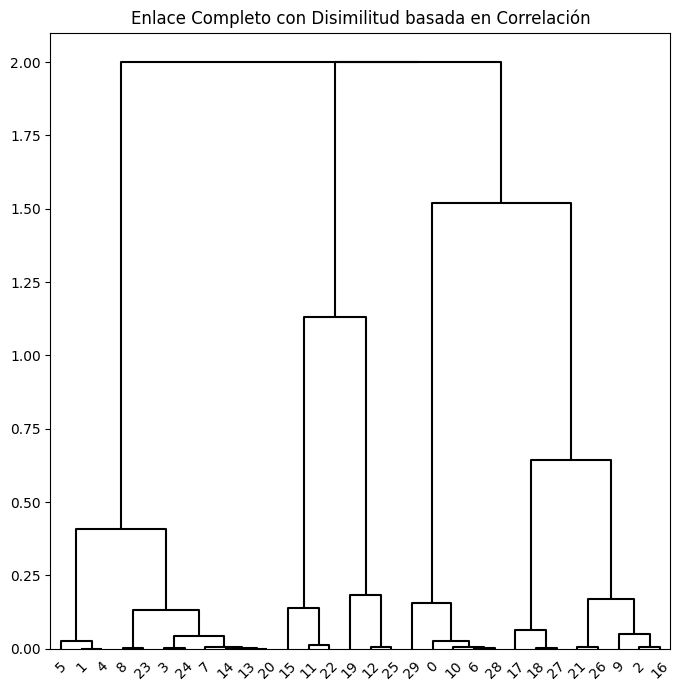

In [56]:
X = np.random.standard_normal((30, 3))
corD = 1 - np.corrcoef(X)
hc_cor = HClust(linkage='complete',
                distance_threshold=0,
                n_clusters=None,
                metric='precomputed')
hc_cor.fit(corD)
linkage_cor = compute_linkage(hc_cor)

fig, ax = plt.subplots(1, 1, figsize=(8, 8))
dendrogram(linkage_cor, ax=ax, **cargs)
ax.set_title("Enlace Completo con Disimilitud basada en Correlación")